In [ ]:
! pip install mplfinance

In [ ]:
! pip install yfinance

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import requests
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
import datetime 

In [3]:
# set tickers
# tickers = ["^GSPC", "EURUSD=X", "USDJPY=X"]
tickers = "SPY"
# set the start date and end date
start = "1985-01-01"
end = "2020-06-30"

In [2]:
df =  yf.download("SPY", start="1985-01-01", end="2020-06-30")

[*********************100%***********************]  1 of 1 completed


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-23,313.489990,314.500000,311.609985,312.049988,309.486603,68471200
2020-06-24,309.839996,310.510010,302.100006,304.089996,301.592010,132813500
2020-06-25,303.470001,307.640015,301.279999,307.350006,304.825226,89468000
2020-06-26,306.160004,306.390015,299.420013,300.049988,297.585205,127961000
2020-06-29,301.410004,304.609985,298.929993,304.459991,301.958954,79773300


In [5]:
# split the dataset into trainset and test
# The last 4 years is the test set  
test_df = df[-252*4:]
train_df = df[:len(df) - 252*4]

In [16]:
train_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,25.968958,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,26.153660,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,26.209057,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,26.486113,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,26.596937,531500


In [53]:
# A function to return the start dates array
def start_dates(dframe, df_start, term_days, ahead_days):
    return np.arange(0, len(dframe)-term_days - ahead_days, int(term_days/3)) # 10 days sliding
    


In [54]:
# Not used yet
# A function to compute the momemtum return
# This function works only inside the candle_stick function
def momentum_ret(df_start, term_days, ahead_days):
    # set the start date and ending date
    df_start = df_start
    df_end = df_start + term_days
    df_flag_date = df_end + ahead_days

    # set the starting date to determine the momentum factor
    df_mom_start = df_end - 5

    # grab the price
    mom_start_price = df[df_mom_start:df_mom_start+1].Close.values 
    final_price = df[df_end:df_end+1].Close.values
    flag_price = df[df_flag_date:df_flag_date+1].Close.values

    # set the strategy and compute the return
    if final_price > mom_start_price*1.05:
        strategy = "long"
        profit = (flag_price - final_price) / final_price

    elif final_price < mom_start_price*0.95:
        strategy = "short"
        profit = (final_price - flag_price) / final_price

    else:
        strategy = "no position"
        profit = 0

    return(strategy, profit)

In [55]:
# A function to return the flag(up, flat, or down)
# This function works only inside the candle_stick function
def three_flags(df_start, term_days, ahead_days):
    df_start = df_start
    df_end = df_start + term_days
    df_flag_date = df_end + ahead_days 
    final_price = df[df_end:df_end+1].Close.values
    flag_price = df[df_flag_date:df_flag_date+1].Close.values

    if flag_price > final_price*1.005:
        flag = "up"
    elif flag_price < final_price*0.995:
        flag = "down"
    else:
        flag = "flat"

    return flag

In [68]:
# A function to create a candle_stick with MA25 and store it to a directory with the first date in its file name
# pass dataframe from the yfinace as the first argument
# The 2nd argument is the start_date index of the datafrtame
# The 3rd argument is the term of the subset dataframe, i.e. set 30 for 30 days
# The 4th argument is the forecaset period, i.e. set 3 for 3 days ahead foracasting
# Set "train" or "test" for the 5th argument  
def candle_stick(dframe, df_start, term_days, ahead_days,test_or_train):
    
    df_start = df_start
    df_end = df_start + term_days

    df = dframe[df_start:df_end]

    # grab the first date in the dataframe
    date_from = str(df.index[0])[:10]
  
    # extract the rows from the original dataframe
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
      
    # rename the columns 
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
  
    # params for the candle stick
    mc = mpf.make_marketcolors(up='g',down='r')
    s  = mpf.make_mpf_style(marketcolors=mc)

    # grab the flag by the three_flags fuinction
    flag = three_flags(df_start, term_days, ahead_days)

    # momentum function 
    strategy, profit = momentum_ret(df_start, term_days, ahead_days)

    # set the directory acoroding to the flag(up,flat, or down)
    # store the image data to a different directory
    dir = flag + "_data" 
  
    # return the plot and save it to a specific directory with unique file name
    # mount on google drive before run this code or you can set other local directory
    # To run a classifier we should either inculde the flag (up, down, or flat) in the file name 
    # or store the files in different directories according to its flag
    # Change the data_# number to store the data into different directories
    return mpf.plot(df,type='candle', mav=13, style=s, figratio=(15,15),savefig='./capstone_data/{}_data_1/{}/{}_mpf_candle_{}.png'.format(test_or_train, dir,flag,date_from))
    f = open('{0}.csv'.format(flag), 'wb')
    

 Execute the funtion

Five days ahead

In [66]:
# Train_set
# Loop over the train set
# Three days ahead
for i_date in start_dates(train_df,0,30,5):
    # execute the function, create candle stick charts and store into the directory
    candle_stick(train_df,i_date,30,5,"train")

In [67]:
# Test_set
# Loop over the test set
# Three days ahead
for i_date in start_dates(test_df,0,30,5):
    # execute the function, create candle stick charts and store into the directory
    candle_stick(test_df,i_date,30,5,"test")

Three days ahead

In [62]:
# Train_set
# Loop over the train set
# Three days ahead
for i_date in start_dates(train_df, 0, 30, 3):
    candle_stick(train_df,i_date,30,3,"train")

In [59]:
# Test_set
# Loop over the test set
# Three days ahead
for i_date in start_dates(test_df, 0, 30, 3):
    # execute the function, create candle stick charts and store into the directory
    candle_stick(test_df,i_date,30,3,"test")

One day ahead

In [69]:
# Train_set
# Loop over the train set
# One days ahead
for i_date in start_dates(train_df,0,30,1):
    # execute the function, create candle stick charts and store into the directory
    candle_stick(train_df,i_date,30,1,"train")

In [71]:
# Test_set
# Loop over the test set
# One days ahead
for i_date in start_dates(test_df,0,30,1):
    # execute the function, create candle stick charts and store into the directory
    candle_stick(test_df,i_date,30,1,"test")

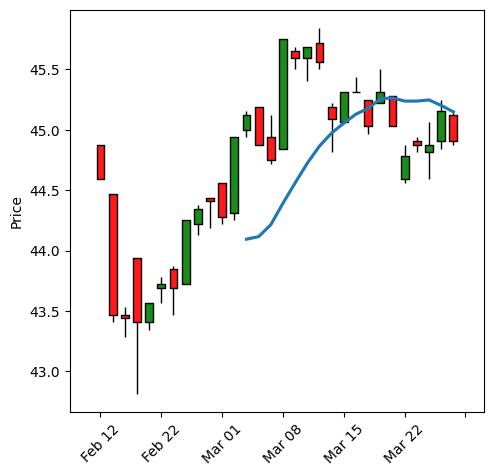

In [63]:
# a sample chart
mc = mpf.make_marketcolors(up='g',down='r')
s  = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(df[10:40],type='candle', mav=13, style=s, figratio=(8,8))

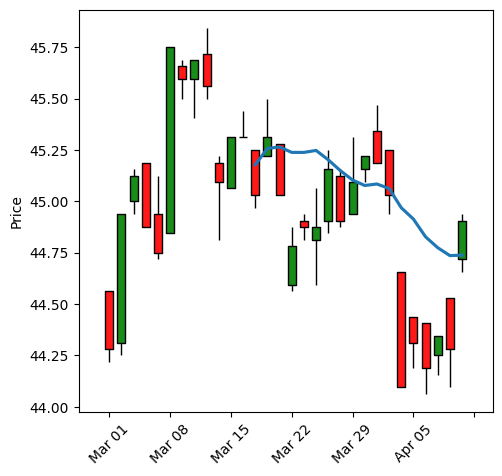

In [64]:
# a sample chart slinding 10 days
mc = mpf.make_marketcolors(up='g',down='r')
s  = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(df[20:50],type='candle', mav=13, style=s, figratio=(8,8))